In [111]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random
import seaborn as sns

In [ ]:
# Improved El Farol Bar Simulation with Peer Communication & Experience Replay
import random
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm

# Parameters
N_AGENTS = 100
BAR_CAPACITY = 60
TOO_FEW = 20
WEEKS = 100
SEQUENCE_LENGTH = 300  # Keep 1:3 ratio for weeks to sequence length
REPLAY_MEMORY_SIZE = 500
REPLAY_BATCH_SIZE = 32

# Generate dummy attendance history with high initial attendance
def generate_initial_attendance(weeks=SEQUENCE_LENGTH):
    return [random.randint(50, 80) for _ in range(weeks)]

# Build LSTM predictor
def build_lstm_model():
    model = Sequential([
        LSTM(32, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Q-learning Agent with LSTM, communication, and experience replay
class Agent:
    def __init__(self, agent_id, total_agents):
        self.agent_id = agent_id
        self.q_table = np.zeros((2,))  # 0: stay home, 1: go
        self.alpha = 0.1
        self.gamma = 0.95
        self.epsilon = 0.5  # Initial exploration rate
        # Experience replay buffer
        self.experience_buffer = []
        self.buffer_size = REPLAY_MEMORY_SIZE

        # LSTM predictor
        self.lstm = build_lstm_model()
        self.past_attendance = generate_initial_attendance()
        self.recent_rewards = []

        # Social peers
        self.known_agents = random.sample(range(total_agents), k=random.randint(1, 10))
        self.comm_weight = random.uniform(0.5, 1.0)

        # Pre-train LSTM on initial history
        X = np.array([
            self.past_attendance[i:i+SEQUENCE_LENGTH]
            for i in range(len(self.past_attendance) - SEQUENCE_LENGTH)
        ])
        y = np.array(self.past_attendance[SEQUENCE_LENGTH:])
        if len(X) > 0:
            self.lstm.fit(
                X.reshape(-1, SEQUENCE_LENGTH, 1),
                y,
                epochs=50,
                verbose=0
            )

    def store_experience(self, state, action, reward, next_state):
        """Store an experience in the replay buffer."""
        if len(self.experience_buffer) >= self.buffer_size:
            self.experience_buffer.pop(0)  # Remove oldest experience
        self.experience_buffer.append((state, action, reward, next_state))

    def replay_experiences(self, batch_size=REPLAY_BATCH_SIZE):
        """Sample a batch of experiences from the buffer and update Q-values."""
        if len(self.experience_buffer) < batch_size:
            return  # Not enough experiences
        batch = random.sample(self.experience_buffer, batch_size)
        for state, action, reward, next_state in batch:
            # Update Q-value using Bellman
            self.q_table[action] += self.alpha * (
                reward + self.gamma * np.max(self.q_table) - self.q_table[action]
            )

    def adjust_epsilon(self):
        if self.recent_rewards:
            avg_reward = np.mean(self.recent_rewards)
            if avg_reward > 1:
                self.epsilon = max(0.1, self.epsilon * 0.95)
            elif avg_reward < 0:
                self.epsilon = min(1.0, self.epsilon * 1.05)

    def predict_attendance(self):
        seq = np.array(self.past_attendance[-SEQUENCE_LENGTH:]).reshape(1, SEQUENCE_LENGTH, 1)
        return self.lstm.predict(seq, verbose=0)[0][0]

    def decide(self, combined_pred, known_rewards):
        if known_rewards:
            avg_known = np.mean(known_rewards)
            if avg_known > 1:
                self.epsilon = max(0.1, self.epsilon * 0.95)
            elif avg_known < 0:
                self.epsilon = min(1.0, self.epsilon * 1.05)
        # Epsilon-greedy
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        return int(np.argmax(self.q_table))

    def update_q(self, action, reward):
        # immediate Q-update
        self.q_table[action] += self.alpha * (
            reward + self.gamma * np.max(self.q_table) - self.q_table[action]
        )
        # track recent rewards
        self.recent_rewards.append(reward)
        if len(self.recent_rewards) > 10:
            self.recent_rewards.pop(0)

    def update_attendance_history(self, value):
        self.past_attendance.append(value)
        if len(self.past_attendance) > SEQUENCE_LENGTH + 1:
            self.past_attendance.pop(0)

# Initialize agents
agents = [Agent(i, N_AGENTS) for i in range(N_AGENTS)]

# Simulation containers
history = generate_initial_attendance(weeks=SEQUENCE_LENGTH)
raw_attendance = []
epsilon_tracking = []

for week in tqdm(range(WEEKS), desc="Simulating Weeks"):
    decisions = []
    predictions = []

    # forecast phase
    for agent in agents:
        predictions.append(agent.predict_attendance())

    # peer-prediction
    peer_preds = []
    for idx, agent in enumerate(agents):
        peers = agent.known_agents
        peer_preds.append(np.mean([predictions[p] for p in peers]) if peers else predictions[idx])

    # decision phase
    for idx, agent in enumerate(agents):
        combined = agent.comm_weight * predictions[idx] + (1 - agent.comm_weight) * peer_preds[idx]
        known_rewards = [agents[p].recent_rewards[-1] for p in agent.known_agents if agents[p].recent_rewards]
        action = agent.decide(combined, known_rewards)
        decisions.append(action)

    # record raw attendance
    attendance_raw = sum(decisions)
    raw_attendance.append(attendance_raw)

    # early leaving
    attendance_final = attendance_raw
    if attendance_final > BAR_CAPACITY:
        leavers = int(0.3 * attendance_final)
        attendance_final -= leavers

    # update history for LSTM
    history.append(attendance_raw)
    history = history[-(SEQUENCE_LENGTH + 1):]

    # reward & replay
    for i, agent in enumerate(agents):
        # compute reward
        if decisions[i] == 1 and attendance_final <= BAR_CAPACITY and attendance_final > TOO_FEW:
            reward = 2
        elif decisions[i] == 1 and attendance_final <= TOO_FEW:
            reward = -2
        elif decisions[i] == 1:
            reward = -1
        else:
            reward = 0.5
        # store
        state = attendance_raw
        next_state = attendance_raw
        agent.store_experience(state, decisions[i], reward, next_state)
        # immediate update
        agent.update_q(decisions[i], reward)
        agent.adjust_epsilon()
        # replay
        agent.replay_experiences()

    epsilon_tracking.append(np.mean([a.epsilon for a in agents]))

# End of simulation


Simulating Weeks: 100%|██████████| 100/100 [13:20<00:00,  8.00s/it]


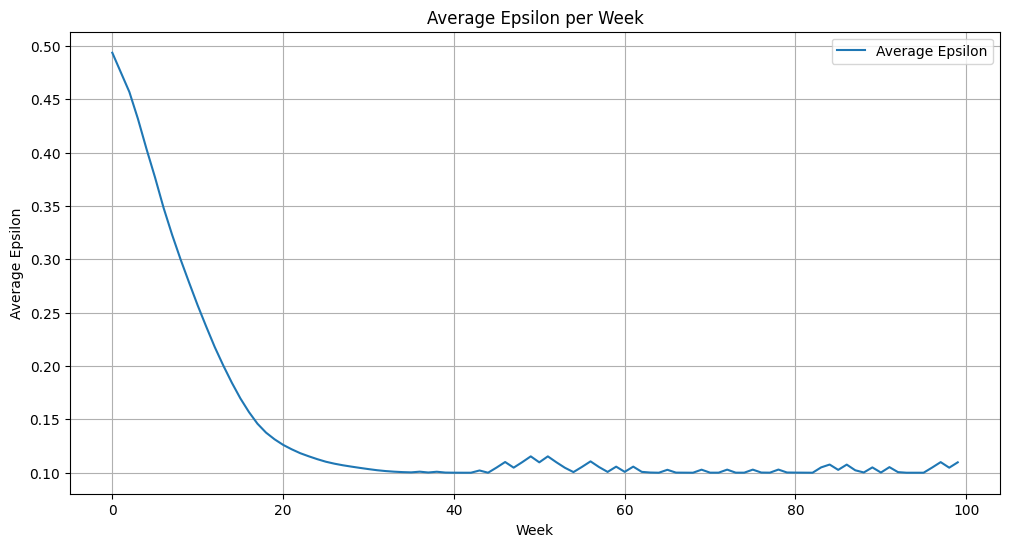

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(WEEKS), epsilon_tracking, label='Average Epsilon')
plt.title('Average Epsilon per Week')
plt.xlabel('Week')
plt.ylabel('Average Epsilon')
plt.grid()
plt.legend()
plt.show()

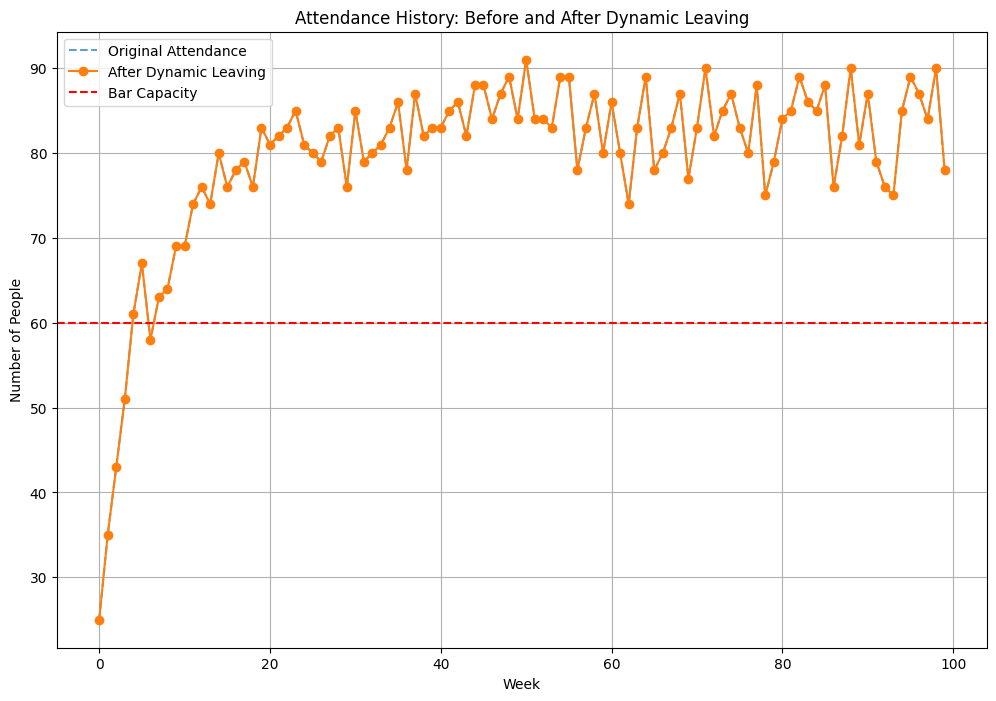

In [114]:

# Plot attendance history with and without dynamic leaving
plt.figure(figsize=(12, 8))
plt.plot(range(WEEKS), raw_attendance[:WEEKS], label='Original Attendance', linestyle='--', alpha=0.7)
plt.plot(range(WEEKS), history[-WEEKS:], label='After Dynamic Leaving', marker='o')
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.title('Attendance History: Before and After Dynamic Leaving')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

In [115]:
print("BAR_CAPACITY:", BAR_CAPACITY)
print("N_AGENTS:", N_AGENTS)
print("SEQUENCE_LENGTH:", SEQUENCE_LENGTH)
print("WEEKS:", WEEKS)
print("Current Week:", week)
print("Attendance:", attendance)
print("Decisions:", decisions)
print("Predictions:", predictions)
print("History:", history)
print("Reward:", reward)

BAR_CAPACITY: 60
N_AGENTS: 100
SEQUENCE_LENGTH: 300
WEEKS: 100
Current Week: 99
Attendance: 59
Decisions: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Predictions: [0.697621, 0.38180578, 0.18189886, 0.5756419, 0.51639134, -0.17789422, 1.0096909, -0.2630145, 1.4845784, -0.28457657, 0.12450418, 0.65940744, 1.2745161, 0.32860523, -0.82970923, 0.29125026, 0.2322527, -0.043810707, 0.9446761, 0.3589003, 0.57090527, 0.8172765, -1.382608, 1.0801905, 0.18576019, 0.89701355, 0.2112965, -0.093150966, -0.11475175, -0.9059967, -0.10764656, -0.33657363, -0.33920595, 0.85402036, 0.56551236, -0.7083337, 0.086426675, -0.9770289, 0.106710546, -0.307237, 0.13304129, 0.110125616, -0.5192846, 0.55187356, 0.034201436, 0.882505, -0.07577704, -0.9622961, 0.0

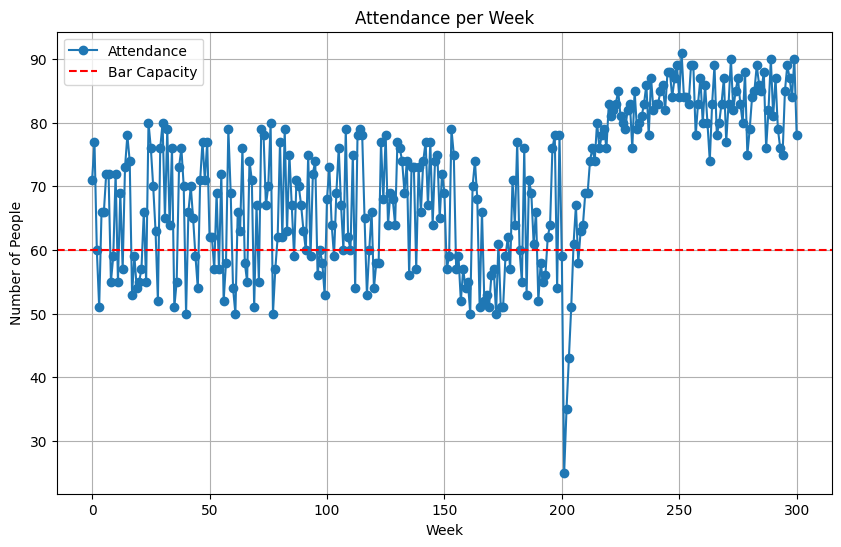

In [116]:
import matplotlib.pyplot as plt

# Plot attendance history
plt.figure(figsize=(10, 6))
plt.plot(range(len(history)), history, marker='o', label='Attendance')
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.title('Attendance per Week')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

In [117]:
from collections import Counter

# Count the frequency of attendance values
attendance_frequency = Counter(history)

# Display the frequency
print("Attendance Frequency per Week:")
for attendance_value, frequency in sorted(attendance_frequency.items()):
    print(f"Attendance: {attendance_value}, Frequency: {frequency}")

Attendance Frequency per Week:
Attendance: 25, Frequency: 1
Attendance: 35, Frequency: 1
Attendance: 43, Frequency: 1
Attendance: 50, Frequency: 5
Attendance: 51, Frequency: 8
Attendance: 52, Frequency: 5
Attendance: 53, Frequency: 5
Attendance: 54, Frequency: 7
Attendance: 55, Frequency: 10
Attendance: 56, Frequency: 4
Attendance: 57, Frequency: 11
Attendance: 58, Frequency: 7
Attendance: 59, Frequency: 10
Attendance: 60, Frequency: 7
Attendance: 61, Frequency: 3
Attendance: 62, Frequency: 7
Attendance: 63, Frequency: 5
Attendance: 64, Frequency: 8
Attendance: 65, Frequency: 4
Attendance: 66, Frequency: 9
Attendance: 67, Frequency: 7
Attendance: 68, Frequency: 4
Attendance: 69, Frequency: 10
Attendance: 70, Frequency: 6
Attendance: 71, Frequency: 7
Attendance: 72, Frequency: 6
Attendance: 73, Frequency: 6
Attendance: 74, Frequency: 11
Attendance: 75, Frequency: 7
Attendance: 76, Frequency: 15
Attendance: 77, Frequency: 10
Attendance: 78, Frequency: 12
Attendance: 79, Frequency: 12
Att

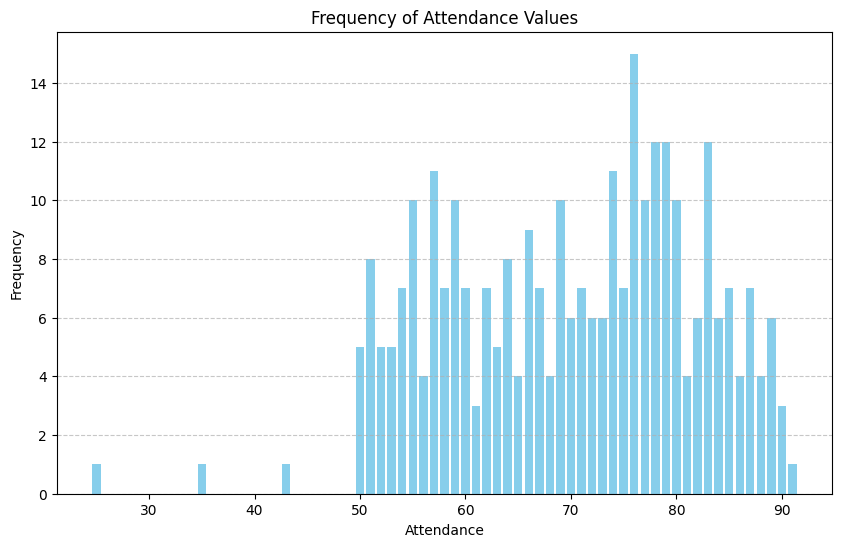

In [118]:
# Visualize the frequency of attendance values
plt.figure(figsize=(10, 6))
plt.bar(attendance_frequency.keys(), attendance_frequency.values(), color='skyblue')
plt.title('Frequency of Attendance Values')
plt.xlabel('Attendance')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


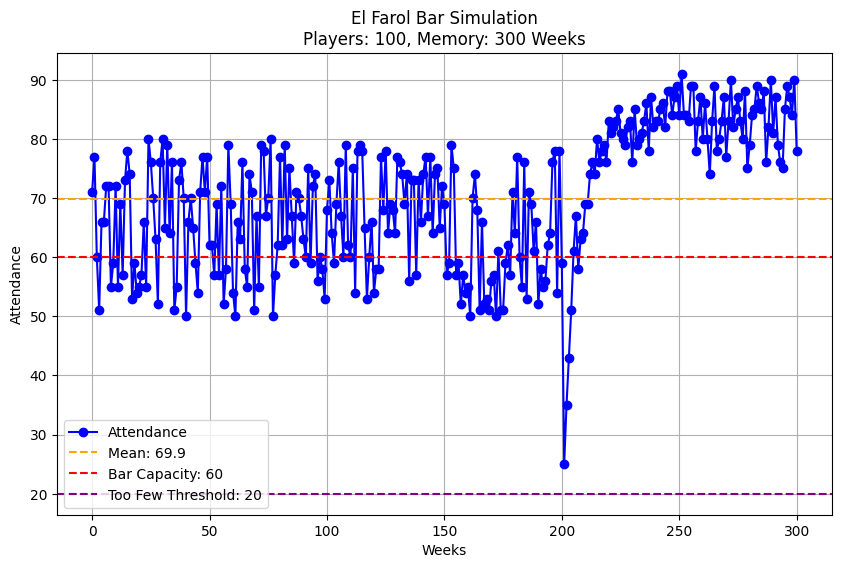

In [119]:
# Calculate the mean attendance
mean_data = np.mean(history)

# Plot the attendance history, mean, bar capacity, and too few threshold
plt.figure(figsize=(10, 6))
plt.plot(history, label='Attendance', marker='o', color='blue')
plt.axhline(y=mean_data, color='orange', linestyle='--', label='Mean: ' + str(round(mean_data, 2)))
plt.axhline(y=BAR_CAPACITY, color='red', linestyle='--', label='Bar Capacity: ' + str(BAR_CAPACITY))
plt.axhline(y=TOO_FEW, color='purple', linestyle='--', label='Too Few Threshold: ' + str(TOO_FEW))
plt.legend()
plt.xlabel("Weeks")
plt.ylabel("Attendance")
plt.grid()
plt.title("El Farol Bar Simulation\nPlayers: " + str(N_AGENTS) + ", Memory: " + str(SEQUENCE_LENGTH) + " Weeks")
plt.show()

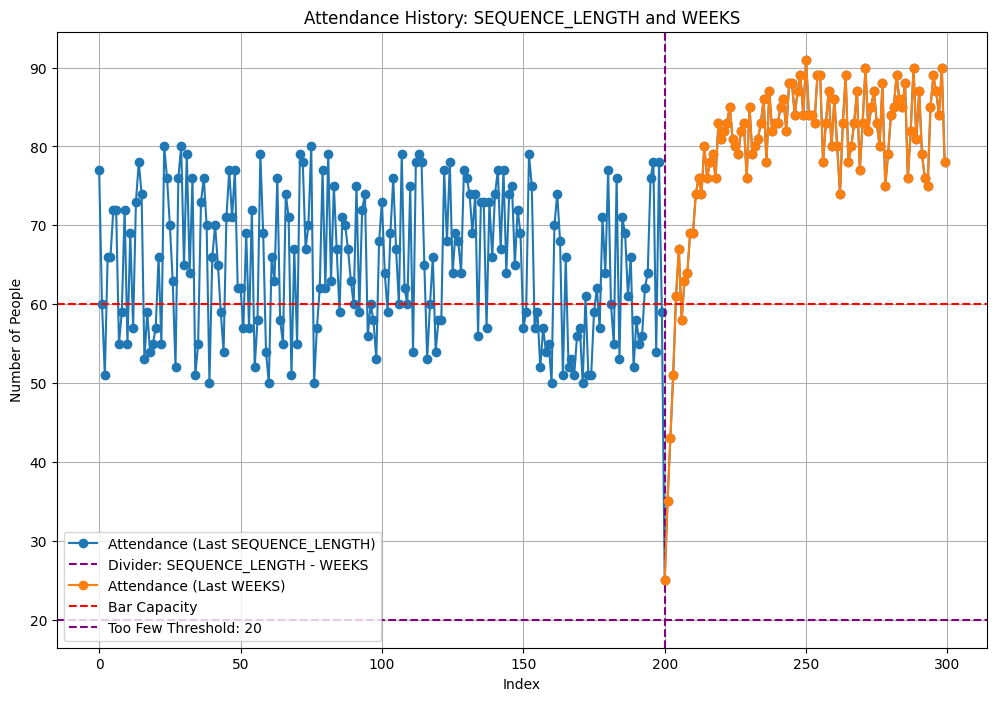

In [120]:
# Plot attendance history for SEQUENCE_LENGTH and WEEKS
plt.figure(figsize=(12, 8))

# Plot data for SEQUENCE_LENGTH
plt.plot(range(SEQUENCE_LENGTH), history[-SEQUENCE_LENGTH:], marker='o', label='Attendance (Last SEQUENCE_LENGTH)')

# Add a divider label
plt.axvline(x=SEQUENCE_LENGTH - WEEKS, color='purple', linestyle='--', label='Divider: SEQUENCE_LENGTH - WEEKS')

# Plot data for WEEKS
plt.plot(range(SEQUENCE_LENGTH - WEEKS, SEQUENCE_LENGTH), history[-WEEKS:], marker='o', label='Attendance (Last WEEKS)')

# Add labels and legend
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.axhline(y=TOO_FEW, color='purple', linestyle='--', label='Too Few Threshold: ' + str(TOO_FEW))
plt.title('Attendance History: SEQUENCE_LENGTH and WEEKS')
plt.xlabel('Index')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

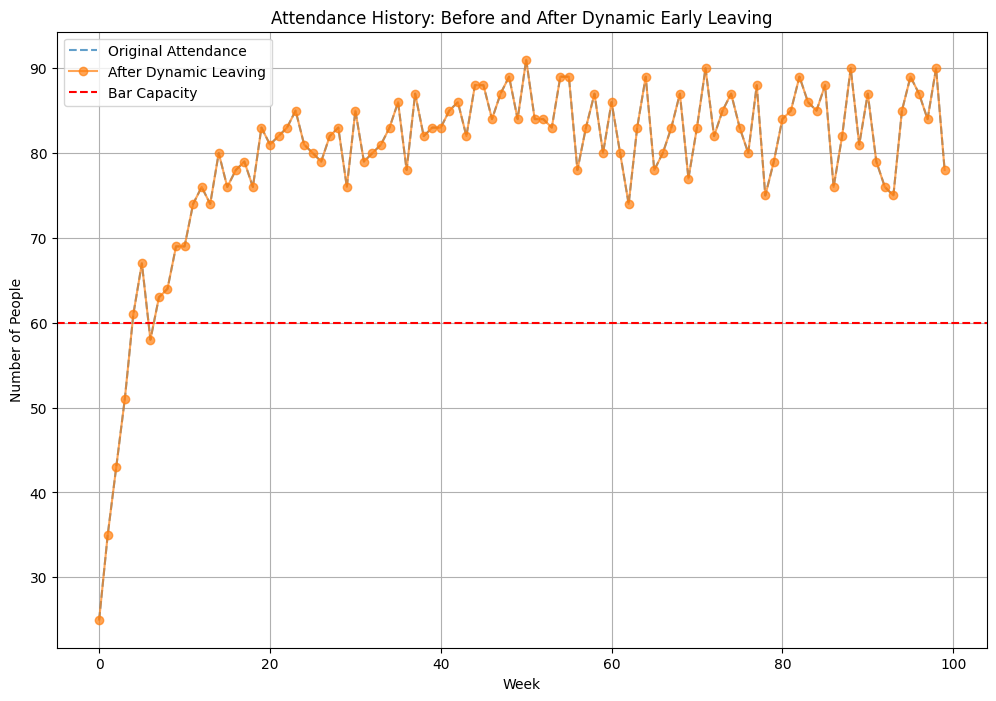

In [121]:
plt.figure(figsize=(12, 8))

# Plot original attendance (before dynamic early leaving)
plt.plot(range(WEEKS), raw_attendance, label='Original Attendance', linestyle='--', alpha=0.7)

# Plot attendance after applying early leaving
plt.plot(range(WEEKS), history[-WEEKS:], label='After Dynamic Leaving', marker='o', alpha=0.7)

# Bar capacity line
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')

plt.title('Attendance History: Before and After Dynamic Early Leaving')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid(True)
plt.show()

In [122]:
for idx, agent in enumerate(agents):
    print(f"Agent {idx}:")
    print(f"  Q-Table: {agent.q_table}")
    print(f"  Epsilon: {agent.epsilon}")
    print(f"  Past Attendance: {agent.past_attendance}")
    print()

Agent 0:
  Q-Table: [24.5975605 24.9760609]
  Epsilon: 0.10997437500000001
  Past Attendance: [67, 63, 60, 76, 75, 56, 78, 79, 70, 72, 68, 62, 53, 59, 54, 58, 63, 67, 50, 69, 66, 71, 65, 52, 69, 62, 51, 67, 58, 63, 62, 52, 68, 58, 66, 56, 79, 79, 72, 70, 62, 72, 60, 66, 79, 71, 75, 66, 80, 76, 54, 67, 80, 73, 61, 76, 63, 64, 62, 74, 66, 78, 67, 80, 76, 60, 57, 53, 73, 70, 70, 61, 55, 62, 58, 75, 54, 72, 60, 64, 80, 50, 77, 57, 63, 53, 73, 65, 76, 55, 74, 61, 51, 74, 79, 77, 72, 75, 72, 54, 52, 64, 70, 74, 62, 60, 53, 55, 58, 59, 74, 70, 62, 64, 80, 77, 72, 63, 52, 52, 69, 69, 69, 74, 61, 60, 53, 64, 65, 69, 61, 57, 79, 56, 56, 74, 73, 56, 62, 53, 60, 54, 64, 73, 68, 66, 54, 55, 77, 56, 57, 50, 57, 64, 65, 61, 63, 65, 70, 72, 79, 69, 53, 62, 78, 67, 78, 58, 56, 55, 69, 69, 71, 65, 66, 79, 71, 53, 56, 77, 79, 70, 50, 53, 51, 56, 76, 72, 61, 70, 70, 56, 53, 71, 58, 67, 76, 68, 58, 61, 57, 64, 80, 68, 68, 74, 60, 58, 63, 77, 77, 57, 60, 52, 65, 66, 65, 57, 53, 79, 65, 51, 52, 80, 68, 64, 5

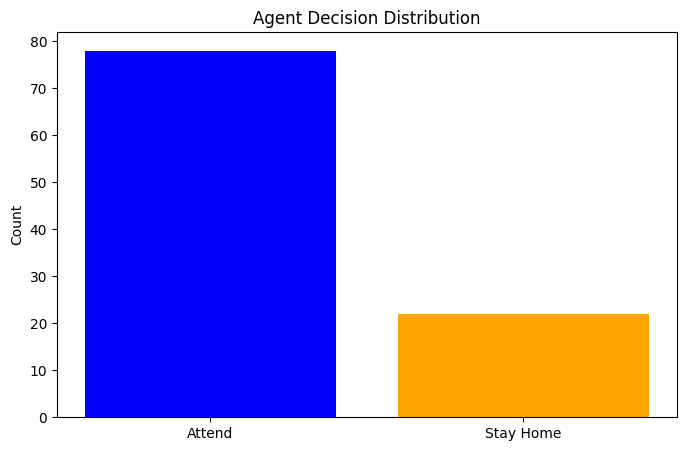

In [123]:
decisions_count = [sum(decisions), len(decisions) - sum(decisions)]
plt.figure(figsize=(8, 5))
plt.bar(['Attend', 'Stay Home'], decisions_count, color=['blue', 'orange'])
plt.title('Agent Decision Distribution')
plt.ylabel('Count')
plt.show()

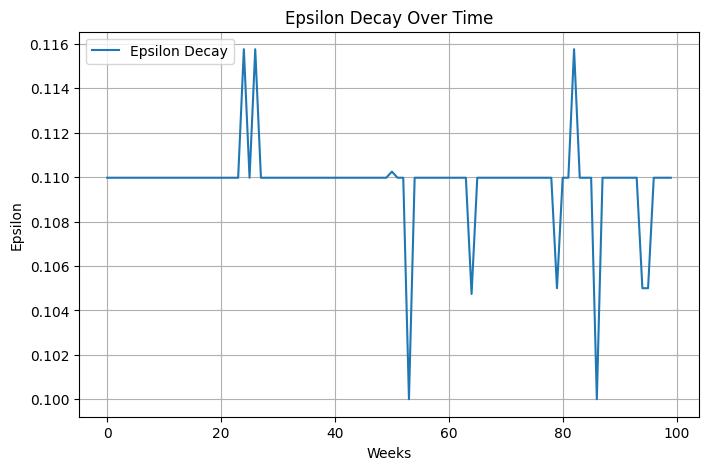

In [124]:
epsilon_values = [agent.epsilon for agent in agents]
plt.figure(figsize=(8, 5))
plt.plot(range(len(epsilon_values)), epsilon_values, label='Epsilon Decay')
plt.title('Epsilon Decay Over Time')
plt.xlabel('Weeks')
plt.ylabel('Epsilon')
plt.grid()
plt.legend()
plt.show()

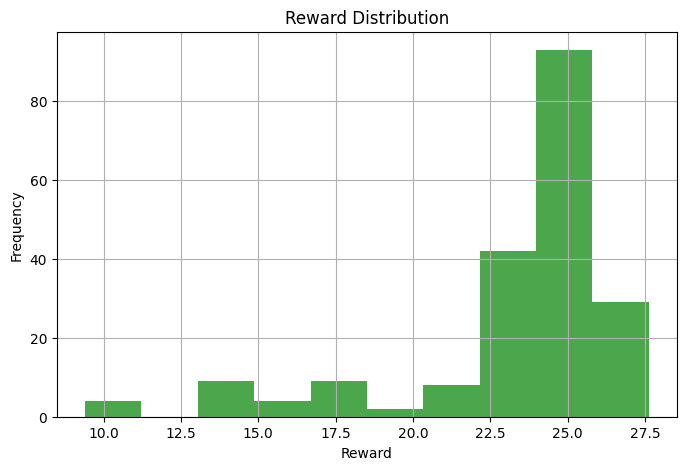

In [125]:
rewards = [reward for agent in agents for reward in agent.q_table]
plt.figure(figsize=(8, 5))
plt.hist(rewards, bins=10, color='green', alpha=0.7)
plt.title('Reward Distribution')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid()
plt.show()

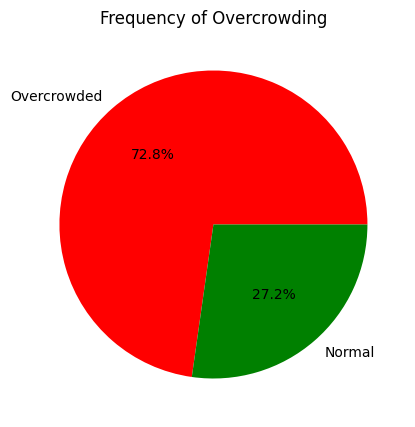

In [126]:
overcrowded_weeks = sum(1 for a in history if a > BAR_CAPACITY)
normal_weeks = len(history) - overcrowded_weeks
plt.figure(figsize=(8, 5))
plt.pie([overcrowded_weeks, normal_weeks], labels=['Overcrowded', 'Normal'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Frequency of Overcrowding')
plt.show()

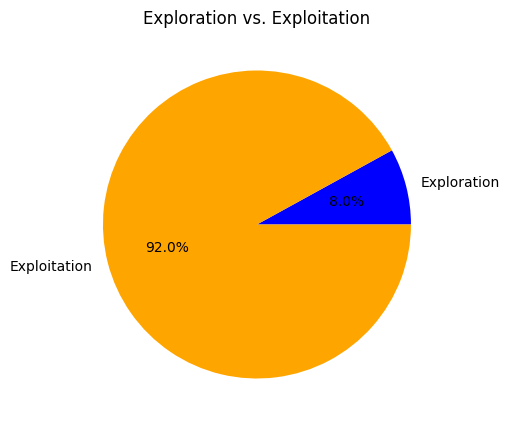

In [127]:
exploration_count = sum(1 for agent in agents if random.random() < agent.epsilon)
exploitation_count = len(agents) - exploration_count
plt.figure(figsize=(8, 5))
plt.pie([exploration_count, exploitation_count], labels=['Exploration', 'Exploitation'], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Exploration vs. Exploitation')
plt.show()

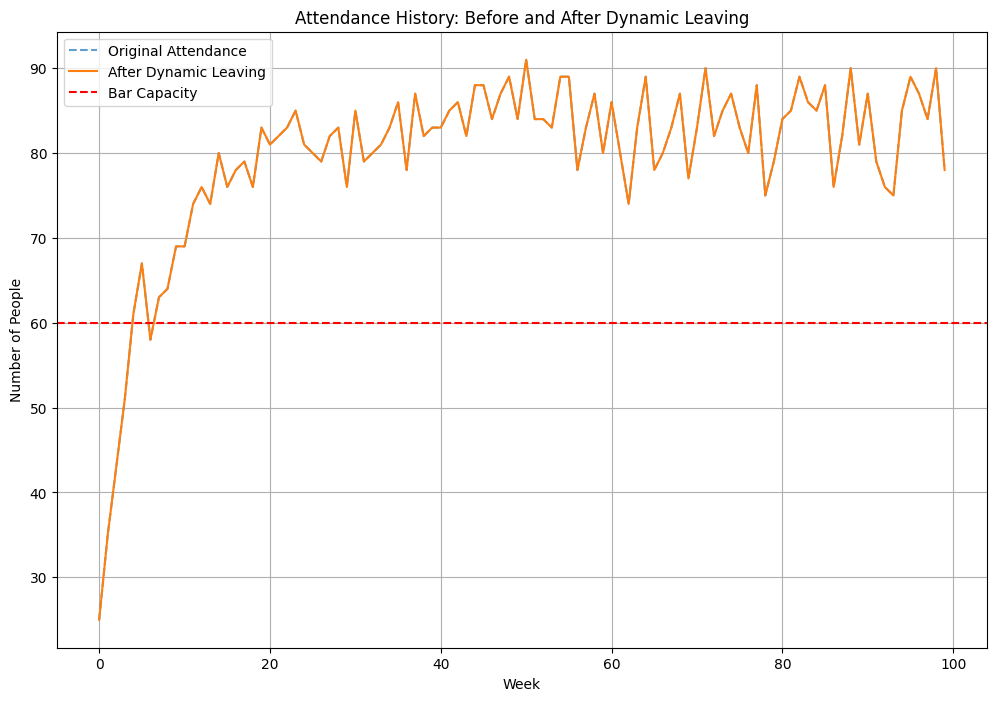

In [128]:
# Plot attendance history with and without dynamic leaving
plt.figure(figsize=(12, 8))
plt.plot(range(WEEKS), raw_attendance[:WEEKS], label='Original Attendance', linestyle='--', alpha=0.7)
plt.plot(range(WEEKS), history[-WEEKS:], label='After Dynamic Leaving')
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.title('Attendance History: Before and After Dynamic Leaving')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()